In [1]:
#Se necessário:
#%pip install pgmpy
#%pip install pandas
#%pip install tensorflow
#%pip install matplotlib
#%pip install scikit-learn

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination

In [153]:
df = pd.read_csv("C:\\Users\\Mafalda Duarte\\Desktop\\Uni\\2ºsem\\APRP\\imdb_movies.csv")
df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10178 entries, 0 to 10177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   names       10178 non-null  object 
 1   date_x      10178 non-null  object 
 2   score       10178 non-null  float64
 3   genre       10093 non-null  object 
 4   overview    10178 non-null  object 
 5   crew        10122 non-null  object 
 6   orig_title  10178 non-null  object 
 7   status      10178 non-null  object 
 8   orig_lang   10178 non-null  object 
 9   budget_x    10178 non-null  float64
 10  revenue     10178 non-null  float64
 11  country     10178 non-null  object 
dtypes: float64(3), object(9)
memory usage: 954.3+ KB


# Valores Em Falta

In [155]:
valor_falta_linha = df.isnull().sum(axis=1)
num_linhas = valor_falta_linha[valor_falta_linha > 0].count()

print("Número total de linhas com valores em falta:", num_linhas , f"-------> {(126*100)/10178}%")

Número total de linhas com valores em falta: 126 -------> 1.2379642365887207%


In [156]:
df = df.dropna()

# Colunas a Retirar

Depois de analisarmos o dataset, decidimos retirar as colunas names, overview, crew, orig_title e country pois achamos que não têm grande importância.

In [157]:
df = df.drop(columns=['names'])
df = df.drop(columns=['overview'])
df = df.drop(columns=['crew'])
df = df.drop(columns=['orig_title'])
df = df.drop(columns=['country'])
df.to_csv('df.csv', index=False)

In [158]:
#df = pd.read_csv('/content/df.csv')
df.head()

,date_x,score,genre,status,orig_lang,budget_x,revenue
0,03/02/2023,73.0,"Drama, Action",Released,English,75000000.0,2.716167e+08
1,12/15/2022,78.0,"Science Fiction, Adventure, Action",Released,English,460000000.0,2.316795e+09
2,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy",Released,English,100000000.0,7.244590e+08
3,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy",Released,"Spanish, Castilian",12300000.0,3.420000e+07
4,03/17/2023,61.0,Action,Released,English,77000000.0,3.409420e+08


In [159]:
unique_status = df['status'].value_counts()
print("Valores únicos na coluna 'status':")
print(unique_status)

Valores únicos na coluna 'status':
status
 Released           10007
 Post Production       30
 In Production         15
Name: count, dtype: int64


In [160]:
df = df[df["status"].str.contains("In Production") == False]
df = df[df["status"].str.contains("Post Production") == False]

In [161]:
df = df.drop(columns=['status'])

# Transformar a coluna date_x em Beginning, Middle, End

In [162]:
beginning_thr = [1, 2, 3, 4] # Janeiro a Abril
mid_thr = [5, 6, 7, 8] # Maio a Agosto
end_thr = [9, 10, 11, 12] # Setembro a Dezembro

def aplicar_thr_date(date):
    month = int(date.split('/')[0])
    if month in beginning_thr:
        return 'Beginning'
    elif month in mid_thr:
        return 'Middle'
    elif month in end_thr:
        return 'End'

df['date_x'] = df['date_x'].apply(aplicar_thr_date)

# Transformar Género em one-hot

In [163]:
unique_genres = df['genre'].value_counts()
print("Valores únicos na coluna 'genre':")
print(unique_genres)

Valores únicos na coluna 'genre':
genre
Drama                                                    556
Comedy                                                   372
Drama, Romance                                           268
Horror                                                   257
Horror, Thriller                                         199
                                                        ... 
Drama, Crime, Comedy                                       1
Action, Adventure, Animation, Science Fiction, Family      1
Family, Animation, Fantasy, Adventure, Comedy, Music       1
Horror, Comedy, Action, Science Fiction, Thriller          1
Action, Adventure, Science Fiction, Thriller, Horror       1
Name: count, Length: 2294, dtype: int64


In [164]:
genres_final = set()
for genres in df['genre'].str.split(','):
  genres_final.update(genres)

for genre in genres_final:
  df[genre.strip()] = 0

for ind, row in df.iterrows():
  genres = row['genre'].split(',')
  for genre in genres:
    df.at[ind, genre.strip()] = 1

df.drop(columns=['genre'], inplace = True)

In [165]:
df.head()

,date_x,score,orig_lang,budget_x,revenue,Horror,Romance,Mystery,Music,TV Movie,...,Action,Science Fiction,Drama,Comedy,Family,Western,Documentary,Adventure,Crime,Fantasy
0,Beginning,73.0,English,75000000.0,2.716167e+08,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1,End,78.0,English,460000000.0,2.316795e+09,0,0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
2,Beginning,76.0,English,100000000.0,7.244590e+08,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1
3,Beginning,70.0,"Spanish, Castilian",12300000.0,3.420000e+07,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1
4,Beginning,61.0,English,77000000.0,3.409420e+08,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [166]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10007 entries, 0 to 10177
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_x           10007 non-null  object 
 1   score            10007 non-null  float64
 2   orig_lang        10007 non-null  object 
 3   budget_x         10007 non-null  float64
 4   revenue          10007 non-null  float64
 5   Horror           10007 non-null  int64  
 6   Romance          10007 non-null  int64  
 7   Mystery          10007 non-null  int64  
 8   Music            10007 non-null  int64  
 9   TV Movie         10007 non-null  int64  
 10  Thriller         10007 non-null  int64  
 11  Animation        10007 non-null  int64  
 12  War              10007 non-null  int64  
 13  History          10007 non-null  int64  
 14  Action           10007 non-null  int64  
 15  Science Fiction  10007 non-null  int64  
 16  Drama            10007 non-null  int64  
 17  Comedy           

# Transformar as colunas score budget_x e revenue em High Medium Low

In [167]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

score_low_thr = df['score'].quantile(0.25)
score_high_thr = df['score'].quantile(0.75)

budget_low_thr= df['budget_x'].quantile(0.25)
budget_high_thr = df['budget_x'].quantile(0.75)

revenue_low_thr= df['revenue'].quantile(0.25)
revenue_high_thr = df['revenue'].quantile(0.75)


fig = make_subplots(rows=3, cols=1, subplot_titles=('Score', 'Budget', 'Revenue'))

fig.add_trace(go.Histogram(x=df['score'], marker=dict(color='skyblue')), row=1, col=1)
fig.add_vline(x=score_low_thr, line=dict(color="red", width=1, dash="dash"), row=1, col=1, name='Low Threshold')
fig.add_vline(x=score_high_thr, line=dict(color="red", width=1, dash="dash"), row=1, col=1, name='High Threshold')

fig.add_trace(go.Histogram(x=df['budget_x'], marker=dict(color='salmon')), row=2, col=1)
fig.add_vline(x=budget_low_thr, line=dict(color="red", width=1, dash="dash"), row=2, col=1, name='Low Threshold')
fig.add_vline(x=budget_high_thr, line=dict(color="red", width=1, dash="dash"), row=2, col=1, name='High Threshold')

fig.add_trace(go.Histogram(x=df['revenue'], marker=dict(color='lightgreen')), row=3, col=1)
fig.add_vline(x=revenue_low_thr, line=dict(color="red", width=1, dash="dash"), row=3, col=1, name='Low Threshold')
fig.add_vline(x=revenue_high_thr, line=dict(color="red", width=1, dash="dash"), row=3, col=1, name='High Threshold')

fig.update_layout(title=dict(text='Histogramas',x=0.5,font=dict(family='Arial Black', size=24, color='black')), plot_bgcolor='whitesmoke', showlegend = False)
fig.show()


In [168]:
def aplicar_thr_score(score):
    if score < score_low_thr:
        return 'Low'
    elif score < score_high_thr:
        return 'Medium'
    else:
        return 'High'

def aplicar_thr_budget(budget):
    if budget < budget_low_thr:
        return 'Low'
    elif budget < budget_high_thr:
        return 'Medium'
    else:
        return 'High'

def aplicar_thr_revenue(revenue):
    if revenue < revenue_low_thr:
        return 'Low'
    elif revenue < revenue_high_thr:
        return 'Medium'
    else:
        return 'High'

df['score_cat'] = df['score'].apply(aplicar_thr_score)
df['budget_cat'] = df['budget_x'].apply(aplicar_thr_budget)
df['revenue_cat'] = df['revenue'].apply(aplicar_thr_revenue)

df.drop(['score', 'budget_x', 'revenue'], axis=1, inplace=True)


# Transformar a lingua de origem em Eng ou Non-Eng

In [169]:
import plotly.express as px

val = df['orig_lang'].value_counts().reset_index()
val.columns = ['orig_lang', 'count']
fig = px.pie(val, values='count', names='orig_lang')
fig.update_traces(textinfo='none')
fig.update_layout(title=dict(text='Distribuição - orig_lang',x=0.5,font=dict(family='Arial Black', size=24, color='black')), plot_bgcolor='whitesmoke', showlegend = True)

fig.show()

In [170]:
df['orig_lang'] = df['orig_lang'].apply(lambda x: 'English' if 'English' in x else 'Non-English')
df['orig_lang'].unique()

array(['English', 'Non-English'], dtype=object)

Depois de terminarmos o nosso pré-processamento e análise dos dados fomos então criar o nosso Baysian Model.

# Criar o Baysian Model

Primeiramente tentamos criar um modelo seguindo apenas a nossa lógica e colocamos as seguintes dependências:

*     ('date_x', 'revenue_cat')
*     ('orig_lang', 'revenue_cat')
*     ('Crime', 'revenue_cat')
*     ('Documentary', 'revenue_cat')
*     ('Comedy', 'revenue_cat')
*     ('War', 'revenue_cat')
*     ('Mystery', 'revenue_cat')
*     ('Romance', 'revenue_cat')
*     ('Action', 'revenue_cat')
*     ('Music', 'revenue_cat')
*     ('Western', 'revenue_cat')
*     ('Science Fiction', 'revenue_cat')
*     ('Adventure', 'revenue_cat')
*     ('Horror', 'revenue_cat')
*     ('Drama', 'revenue_cat')
*     ('Animation', 'revenue_cat')
*     ('Fantasy', 'revenue_cat')
*     ('TV Movie', 'revenue_cat')
*     ('Family', 'revenue_cat')
*     ('History', 'revenue_cat')
*     ('Thriller', 'revenue_cat')
*     ('score_cat', 'revenue_cat')
*     ('budget_cat', 'revenue_cat')
*     ('Crime', 'budget_cat')
*     ('Documentary', 'budget_cat')
*     ('Comedy', 'budget_cat')
*     ('War', 'budget_cat')
*     ('Mystery', 'budget_cat')
*     ('Romance', 'budget_cat')
*     ('Action', 'budget_cat')
*     ('Music', 'budget_cat')
*     ('Western', 'budget_cat')
*     ('Science Fiction', 'budget_cat')
*     ('Adventure', 'budget_cat')
*     ('Horror', 'budget_cat')
*     ('Drama', 'budget_cat')
*     ('Animation', 'budget_cat')
*     ('Fantasy', 'budget_cat')
*     ('TV Movie', 'budget_cat')
*     ('Family', 'budget_cat')
*     ('History', 'budget_cat')
*     ('Thriller', 'budget_cat')

No entanto por motivos computacionais não conseguimos obter as tabelas cpd.


### Opções:

#### Modelo - K2

In [171]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, K2Score

modelo = BayesianModel()

hc = HillClimbSearch(df)
modelo_k2 = hc.estimate(scoring_method=K2Score(df))

print(modelo_k2.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('date_x', 'budget_cat'), ('date_x', 'revenue_cat'), ('date_x', 'score_cat'), ('date_x', 'Family'), ('orig_lang', 'Animation'), ('orig_lang', 'budget_cat'), ('orig_lang', 'revenue_cat'), ('orig_lang', 'score_cat'), ('orig_lang', 'Comedy'), ('orig_lang', 'Drama'), ('Horror', 'Drama'), ('Horror', 'score_cat'), ('Horror', 'Crime'), ('Horror', 'Mystery'), ('Horror', 'budget_cat'), ('Horror', 'revenue_cat'), ('Horror', 'Comedy'), ('Horror', 'Adventure'), ('Horror', 'orig_lang'), ('Horror', 'Fantasy'), ('Horror', 'Action'), ('Horror', 'Music'), ('Horror', 'Thriller'), ('Horror', 'Romance'), ('Romance', 'Action'), ('Romance', 'Thriller'), ('Romance', 'budget_cat'), ('Romance', 'revenue_cat'), ('Romance', 'Crime'), ('Romance', 'Drama'), ('Romance', 'Science Fiction'), ('Romance', 'score_cat'), ('Romance', 'Adventure'), ('Romance', 'Animation'), ('Mystery', 'budget_cat'), ('Mystery', 'revenue_cat'), ('Mystery', 'score_cat'), ('Music', 'budget_cat'), ('Music', 'revenue_cat'), ('Music', 'score_c

Note: you may need to restart the kernel to use updated packages.


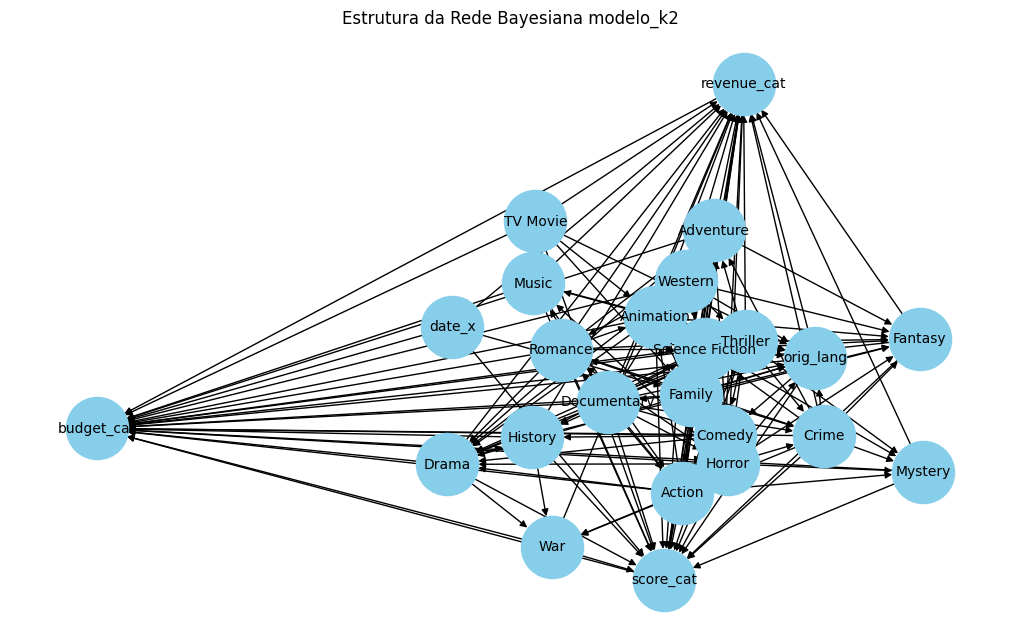

In [172]:
%pip install networkx
import networkx as nx
import matplotlib.pyplot as plt

arestas = modelo_k2.edges()
grafo = nx.DiGraph()
grafo.add_edges_from(arestas)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, arrows=True)
plt.title("Estrutura da Rede Bayesiana modelo_k2")
plt.show()


#### Modelo - BDeu

In [173]:
from pgmpy.estimators import HillClimbSearch, BDeuScore, BicScore

modelo = BayesianModel()

hc = HillClimbSearch(df)
modelo_bdeu = hc.estimate(scoring_method=BDeuScore(df))


  0%|          | 0/1000000 [00:00<?, ?it/s]

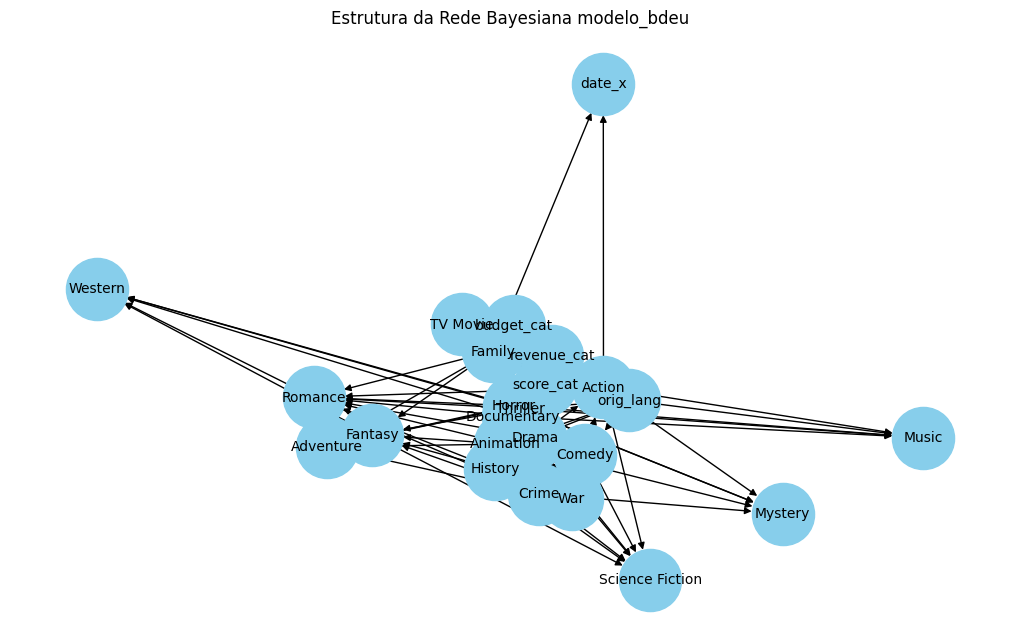

In [174]:
arestas = modelo_bdeu.edges()
grafo = nx.DiGraph()
grafo.add_edges_from(arestas)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, arrows=True)
plt.title("Estrutura da Rede Bayesiana modelo_bdeu")
plt.show()


#### Modelo Bic

In [175]:
from pgmpy.estimators import HillClimbSearch, BDeuScore, BicScore

modelo = BayesianModel()

hc = HillClimbSearch(df)
modelo_bic = hc.estimate(scoring_method=BicScore(df))

  0%|          | 0/1000000 [00:00<?, ?it/s]

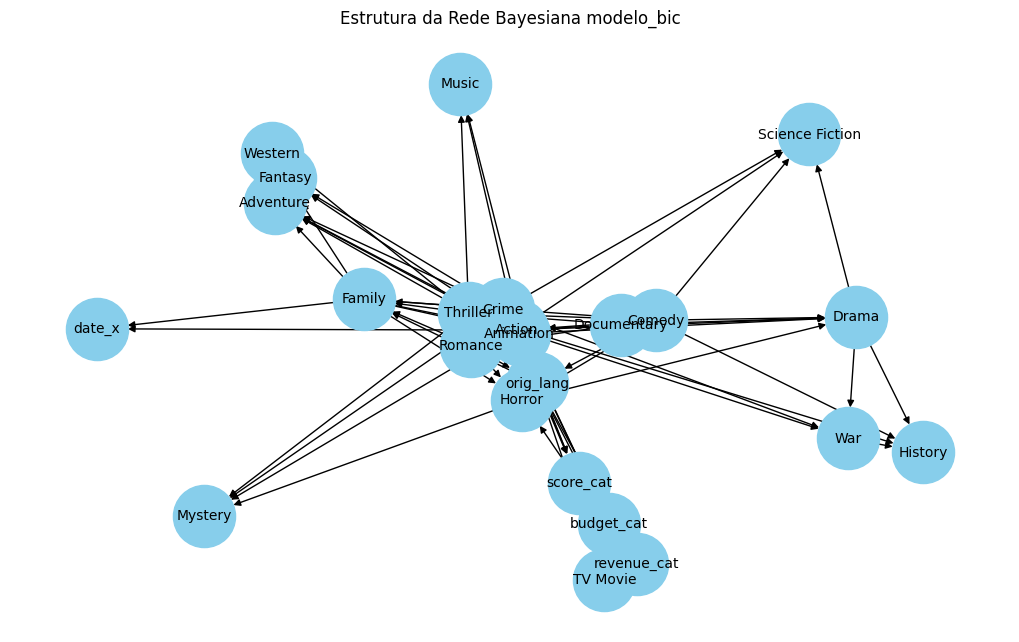

In [176]:
arestas = modelo_bic.edges()
grafo = nx.DiGraph()
grafo.add_edges_from(arestas)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, arrows=True)
plt.title("Estrutura da Rede Bayesiana modelo_bic")
plt.show()

In [177]:
modelo_bic.edges()

OutEdgeView([('orig_lang', 'Animation'), ('orig_lang', 'budget_cat'), ('orig_lang', 'revenue_cat'), ('orig_lang', 'Family'), ('orig_lang', 'score_cat'), ('orig_lang', 'TV Movie'), ('orig_lang', 'Music'), ('Horror', 'Drama'), ('Horror', 'Crime'), ('Horror', 'Mystery'), ('Romance', 'Action'), ('Romance', 'Horror'), ('Romance', 'Family'), ('Romance', 'Crime'), ('Romance', 'orig_lang'), ('Thriller', 'Family'), ('Thriller', 'Crime'), ('Thriller', 'Mystery'), ('Thriller', 'Romance'), ('Thriller', 'Music'), ('Thriller', 'Adventure'), ('Thriller', 'Animation'), ('Thriller', 'History'), ('Thriller', 'Western'), ('Thriller', 'orig_lang'), ('Animation', 'Drama'), ('Animation', 'score_cat'), ('Animation', 'Fantasy'), ('Animation', 'budget_cat'), ('Animation', 'Adventure'), ('War', 'History'), ('Action', 'Adventure'), ('Action', 'Drama'), ('Action', 'Science Fiction'), ('Action', 'Horror'), ('Action', 'Mystery'), ('Action', 'Animation'), ('Action', 'budget_cat'), ('Action', 'Music'), ('Action', 'sc

# SCores

In [178]:
# Modelo K2

bdeu = BDeuScore(df)
k2 = K2Score(df)
bic = BicScore(df)

print(bdeu.score(modelo_k2))
print(k2.score(modelo_k2))
print(bic.score(modelo_k2))

-153839.6082009831
28234285.83613094
-376788039.73716694


In [179]:
# Modelo BDeu

bdeu = BDeuScore(df)
k2 = K2Score(df)
bic = BicScore(df)

print(bdeu.score(modelo_bdeu))
print(k2.score(modelo_bdeu))
print(bic.score(modelo_bdeu))

-101818.0151164442
-101798.33966700967
-105808.35453552692


In [180]:
# Bic

bdeu = BDeuScore(df)
k2 = K2Score(df)
bic = BicScore(df)

print(bdeu.score(modelo_bic))
print(k2.score(modelo_bic))
print(bic.score(modelo_bic))

-102356.77410971973
-102363.26354586084
-103036.57074813957


In [181]:
# Modelo - se houver em pelo menos 2 adiciona

a = set(modelo_bdeu.edges())
b = set(modelo_bic.edges())
c = set(modelo.edges())
new = set()

for aresta in a:
    if aresta in b or aresta in c:
        new.add(aresta)

for aresta in b:
    if aresta in a or aresta in c:
        new.add(aresta)

for aresta in c:
    if aresta in a or aresta in b:
        new.add(aresta)

modelo_ = BayesianModel(new)

bdeu = BDeuScore(df)
k2 = K2Score(df)
bic = BicScore(df)

print(bdeu.score(modelo_))
print(k2.score(modelo_))
print(bic.score(modelo_))

-106674.57346751724
-106677.93483448854
-106867.62241133039


In [182]:
# Modelo Inter

a = set(modelo_bdeu.edges())
b = set(modelo_bic.edges())
c = set(modelo_k2.edges())

intersecao = a.intersection(b, c)

print("Interseção das arestas:", intersecao)

intersecao.add(('date_x', 'revenue_cat'))
intersecao.add(('score_cat', 'revenue_cat'))
intersecao.add(('budget_cat', 'revenue_cat'))

modelo_inter = BayesianModel(list(intersecao))

bdeu_score = bdeu.score(modelo_inter)
k2_score = k2.score(modelo_inter)
bic_score = bic.score(modelo_inter)

print(bdeu.score(modelo_inter))
print(k2.score(modelo_inter))
print(bic.score(modelo_inter))

Interseção das arestas: {('Crime', 'Mystery'), ('Documentary', 'Comedy'), ('Documentary', 'Drama'), ('Thriller', 'Crime'), ('Horror', 'Crime'), ('Family', 'Fantasy'), ('Drama', 'War'), ('Crime', 'Fantasy'), ('Documentary', 'Action'), ('Animation', 'Adventure'), ('Action', 'Science Fiction'), ('Action', 'Adventure'), ('Thriller', 'Mystery'), ('Romance', 'Crime'), ('Horror', 'Mystery'), ('Family', 'Action'), ('Documentary', 'Romance'), ('Documentary', 'Thriller'), ('Family', 'Crime'), ('Action', 'Mystery'), ('Thriller', 'Music'), ('Crime', 'Science Fiction'), ('Family', 'Adventure'), ('Crime', 'Adventure'), ('score_cat', 'revenue_cat'), ('Animation', 'Fantasy'), ('orig_lang', 'Animation'), ('Action', 'War'), ('Adventure', 'Fantasy')}
-106258.92908712615
-106213.54947197926
-106428.85868732516


In [183]:
# Modelo Bic Modificado

remover = [('Thriller', 'orig_lang'),
('Comedy', 'orig_lang'),
('Romance', 'orig_lang'),
('revenue_cat', 'budget_cat'),
('score_cat', 'budget_cat')]

modelo_bic.remove_edges_from(remover)

adicionar = [('date_x', 'revenue_cat'),
             ('score_cat', 'revenue_cat'),
              ('budget_cat', 'revenue_cat') ]

modelo_bic.add_edges_from(adicionar)

bdeu = BDeuScore(df)
k2 = K2Score(df)
bic = BicScore(df)

print(bdeu.score(modelo_bic))
print(k2.score(modelo_bic))
print(bic.score(modelo_bic))

-102699.94319001267
-102650.01015299433
-103463.3535946453


In [184]:
# Modelo K2 Modificado

remover = [('orig_lang', 'budget_cat'),
           ('date_x', 'score_cat'),
           ('date_x', 'Family'),
           ('Family', 'orig_lang'),
           ('Science Fiction', 'orig_lang'),
           ('Thriller', 'orig_lang'),
           ('Music', 'orig_lang'),
           ('Crime', 'orig_lang'),
           ('orig_lang', 'score_cat'),
           ('Documentary', 'orig_lang'),
           ('Western', 'orig_lang'),
           ('TV Movie', 'orig_lang'),
           ('revenue_cat', 'budget_cat'),
           ('score_cat', 'budget_cat')]

modelo_k2.remove_edges_from(remover)

modelo = BayesianModel(modelo_k2)

bdeu = BDeuScore(df)
k2 = K2Score(df)
bic = BicScore(df)

print(bdeu.score(modelo))
print(k2.score(modelo))
print(bic.score(modelo))

-145009.27291906768
7885775.67955496
-106354716.4737432


# Cpds

In [185]:

modelo = BayesianModel(modelo_bic.edges())

modelo.fit(df, estimator=BayesianEstimator, prior_type="BDeu")

for node in modelo.nodes():
    print(modelo.get_cpds(node))

+-------------------+-----+---------------------+
| Action            | ... | Action(1)           |
+-------------------+-----+---------------------+
| Family            | ... | Family(1)           |
+-------------------+-----+---------------------+
| date_x(Beginning) | ... | 0.28448665762098596 |
+-------------------+-----+---------------------+
| date_x(End)       | ... | 0.38760741745816374 |
+-------------------+-----+---------------------+
| date_x(Middle)    | ... | 0.3279059249208503  |
+-------------------+-----+---------------------+
+---------------------+-----+------------------------+
| budget_cat          | ... | budget_cat(Medium)     |
+---------------------+-----+------------------------+
| date_x              | ... | date_x(Middle)         |
+---------------------+-----+------------------------+
| orig_lang           | ... | orig_lang(Non-English) |
+---------------------+-----+------------------------+
| score_cat           | ... | score_cat(Medium)      |
+---------

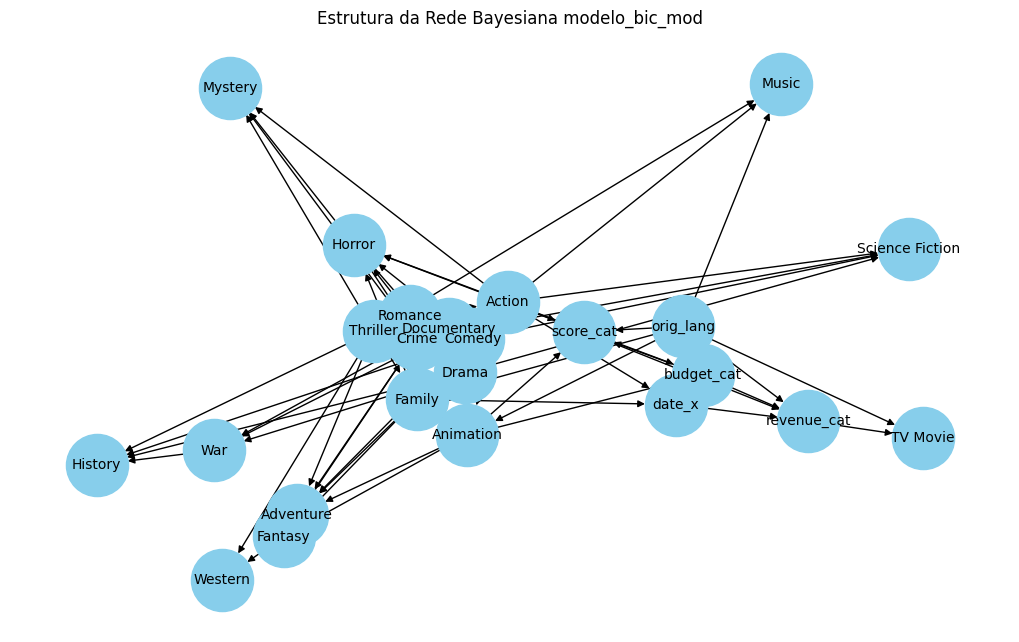

In [186]:
arestas = modelo.edges()
grafo = nx.DiGraph()
grafo.add_edges_from(arestas)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(grafo)
nx.draw(grafo, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, arrows=True)
plt.title("Estrutura da Rede Bayesiana modelo_bic_mod")
plt.show()

# Inferências

In [188]:
infer = VariableElimination(modelo)

# Probabilidade de ser uma animação
q = infer.query(variables=["Animation"])
print(q)


+--------------+------------------+
| Animation    |   phi(Animation) |
+==============+==================+
| Animation(0) |           0.8570 |
+--------------+------------------+
| Animation(1) |           0.1430 |
+--------------+------------------+


In [189]:

# A probabilidade da receita sabendo que o filme é de ação e aventura
q = infer.query(variables=["revenue_cat"], evidence={"Action": 1,"Adventure":1})
print(q)



+---------------------+--------------------+
| revenue_cat         |   phi(revenue_cat) |
+=====================+====================+
| revenue_cat(High)   |             0.2728 |
+---------------------+--------------------+
| revenue_cat(Low)    |             0.2313 |
+---------------------+--------------------+
| revenue_cat(Medium) |             0.4959 |
+---------------------+--------------------+


In [190]:
# A probabilidade do budget_cat sabendo que o filme é de sci-fi
q = infer.query(variables=["budget_cat"], evidence={"Science Fiction":1})
print(q)


+--------------------+-------------------+
| budget_cat         |   phi(budget_cat) |
+====================+===================+
| budget_cat(High)   |            0.2645 |
+--------------------+-------------------+
| budget_cat(Low)    |            0.2242 |
+--------------------+-------------------+
| budget_cat(Medium) |            0.5113 |
+--------------------+-------------------+


In [191]:
# A probabilidade do budget_cat sabendo que o filme é de sci-fi
q = infer.query(variables=["revenue_cat"], evidence={"Science Fiction":1})
print(q)

+---------------------+--------------------+
| revenue_cat         |   phi(revenue_cat) |
+=====================+====================+
| revenue_cat(High)   |             0.2620 |
+---------------------+--------------------+
| revenue_cat(Low)    |             0.2415 |
+---------------------+--------------------+
| revenue_cat(Medium) |             0.4964 |
+---------------------+--------------------+


In [192]:

# A probabilidade conjunta das variáveis Comédia e Romance sabendo que a receita foi alta
q = infer.query(variables=["Comedy", "Romance"], evidence={"revenue_cat": 'High'})
print(q)


+-----------+------------+-----------------------+
| Comedy    | Romance    |   phi(Comedy,Romance) |
+===========+============+=======================+
| Comedy(0) | Romance(0) |                0.6014 |
+-----------+------------+-----------------------+
| Comedy(0) | Romance(1) |                0.0949 |
+-----------+------------+-----------------------+
| Comedy(1) | Romance(0) |                0.2493 |
+-----------+------------+-----------------------+
| Comedy(1) | Romance(1) |                0.0544 |
+-----------+------------+-----------------------+


In [193]:
# A probabilidade conjunta das variáveis Horror e Thriller sabendo que o filme é uma animação
q = infer.query(variables=["Horror", "Thriller"], evidence={"Animation": 1})
print(q)

+-----------+-------------+------------------------+
| Horror    | Thriller    |   phi(Horror,Thriller) |
+===========+=============+========================+
| Horror(0) | Thriller(0) |                 0.9264 |
+-----------+-------------+------------------------+
| Horror(0) | Thriller(1) |                 0.0235 |
+-----------+-------------+------------------------+
| Horror(1) | Thriller(0) |                 0.0465 |
+-----------+-------------+------------------------+
| Horror(1) | Thriller(1) |                 0.0036 |
+-----------+-------------+------------------------+


In [194]:
# A probabilidade conjunta da receita e do score sabendo que o budget é pequeno
q = infer.query(variables=["revenue_cat", "score_cat"], evidence={"budget_cat": 'Low'})
print(q)

+---------------------+-------------------+------------------------------+
| revenue_cat         | score_cat         |   phi(revenue_cat,score_cat) |
+=====================+===================+==============================+
| revenue_cat(High)   | score_cat(High)   |                       0.0020 |
+---------------------+-------------------+------------------------------+
| revenue_cat(High)   | score_cat(Low)    |                       0.0005 |
+---------------------+-------------------+------------------------------+
| revenue_cat(High)   | score_cat(Medium) |                       0.0001 |
+---------------------+-------------------+------------------------------+
| revenue_cat(Low)    | score_cat(High)   |                       0.1933 |
+---------------------+-------------------+------------------------------+
| revenue_cat(Low)    | score_cat(Low)    |                       0.1613 |
+---------------------+-------------------+------------------------------+
| revenue_cat(Low)    | s

In [196]:
# A probabilidade (não conjunta) da receita e do budget sabendo que a lingua é não inglesa
q = infer.query(variables=["revenue_cat", "budget_cat"], evidence={"orig_lang": 'Non-English'}, joint=False)
for factor in q.values():
   print(factor)

+---------------------+--------------------+
| revenue_cat         |   phi(revenue_cat) |
+=====================+====================+
| revenue_cat(High)   |             0.3685 |
+---------------------+--------------------+
| revenue_cat(Low)    |             0.2090 |
+---------------------+--------------------+
| revenue_cat(Medium) |             0.4224 |
+---------------------+--------------------+
+--------------------+-------------------+
| budget_cat         |   phi(budget_cat) |
+====================+===================+
| budget_cat(High)   |            0.3508 |
+--------------------+-------------------+
| budget_cat(Low)    |            0.2129 |
+--------------------+-------------------+
| budget_cat(Medium) |            0.4363 |
+--------------------+-------------------+


In [199]:
# A probabilidade (não conjunta) da receita e do budget sabendo que a lingua é inglesa
q = infer.query(variables=["revenue_cat", "budget_cat"], evidence={"orig_lang": 'English'}, joint=False)
for factor in q.values():
   print(factor)

+---------------------+--------------------+
| revenue_cat         |   phi(revenue_cat) |
+=====================+====================+
| revenue_cat(High)   |             0.2089 |
+---------------------+--------------------+
| revenue_cat(Low)    |             0.2650 |
+---------------------+--------------------+
| revenue_cat(Medium) |             0.5261 |
+---------------------+--------------------+
+--------------------+-------------------+
| budget_cat         |   phi(budget_cat) |
+====================+===================+
| budget_cat(High)   |            0.2132 |
+--------------------+-------------------+
| budget_cat(Low)    |            0.2589 |
+--------------------+-------------------+
| budget_cat(Medium) |            0.5279 |
+--------------------+-------------------+
